In [1]:
import numpy as np
from scipy.signal import hilbert
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import emd
from scipy.ndimage import gaussian_filter1d
from scipy.fft import fft, fftfreq

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

## Восстановление абсолютных значений для тканевой оксиметрии
Содержание jupyter notebook (ссылки):
1. [Получениe исходных данных с оксиметра](#gett) (раздел отчета 5.2)

Методы получения абсолютных значений (раздел 6):

2. [Метод расширяющегося окна](#large_window) (раздел 6.1.1)
3. [Восстановление по пульсовым колебаниям](#pulse) (раздел 6.1.2)
4. [Восстановление по дыхательным колебаниям](#breath) (раздел 6.1.2)

<a id='gett'></a>
### Алгоритм расчета исходных физиологических параметров по данным оксиметра

(раздел 5.2 отчета)

Input: название файла, записанного оксиметром, расстояния между источниками и приемником, длины волн источников

Output: значения параметров StO2, D_Hb, $\Delta$ HbO, $\Delta$ HHb, $\Delta$ THb, Time - временных отметок измерений, $\Delta \mu_A(\lambda _1)$ и $\Delta \mu_A(\lambda _2)$

(эта функция есть в файле get_signals.py)

In [3]:
#filename - название файла, записанного оксиметром, r_1 и r_2 - расстояния между источниками и приемником
def get_signals(filename, r_1, r_2, lmbd_1, lmbd_2): #lmbd_1 и lmbd_2 - длины волн источников
    df = pd.read_excel(filename)
    dc_1 = df["DC 1 A"].values # сигнал, записанный для lmbd2, r1
    dc_3 = df["DC 3 A"].values # lmbd2, r2
    dc_5 = df["DC 5 A"].values # lmbd1, r1
    dc_7 = df["DC 7 A"].values # lmbd1, r2
    time = df["Time"].values # временные отметки измерений
    eps_hhb = {692: 4.7564, 834: 1.7891} #табличные значения для возможных длин волн
    eps_hbo = {692: 0.9558, 834: 2.3671}
    sl = dict() # значения Sl_DC
    sl[lmbd_1] = (np.log(dc_7 / dc_5) + 2 * np.log(r_2 / r_1)) / (r_2 - r_1)
    sl[lmbd_2] = (np.log(dc_3 / dc_1) + 2 * np.log(r_2 / r_1)) / (r_2 - r_1)
    sto2 = (eps_hhb[lmbd_1] - eps_hhb[lmbd_2] * np.square(sl[lmbd_1] / sl[lmbd_2])) * 100
    sto2 /= ((eps_hhb[lmbd_1] - eps_hbo[lmbd_1]) - (eps_hhb[lmbd_2] - eps_hbo[lmbd_2]) * \
                    np.square(sl[lmbd_1] / sl[lmbd_2]))
    dpf = 5.9 # табличное значение
    d_mua_1 = (1 / (r_1 * dpf)) * np.log(dc_1[0] / dc_1)
    d_mua_3 = (1 / (r_2 * dpf)) * np.log(dc_3[0] / dc_3)
    d_mua_lmbd2 = (d_mua_1 + d_mua_3) / 2
    d_mua_5 = (1 / (r_1 * dpf)) * np.log(dc_5[0] / dc_5)
    d_mua_7 = (1 / (r_2 * dpf)) * np.log(dc_7[0] / dc_7)
    d_mua_lmbd1 = (d_mua_5 + d_mua_7) / 2
    d_hbo = (d_mua_lmbd2 * eps_hhb[lmbd_1] - d_mua_lmbd1 * eps_hhb[lmbd_2]) / \
    (eps_hbo[lmbd_2] * eps_hhb[lmbd_1] - eps_hbo[lmbd_1] * eps_hhb[lmbd_2]) * 1000
    d_hhb = (d_mua_lmbd1 * eps_hbo[lmbd_2] - d_mua_lmbd2 * eps_hbo[lmbd_1]) / \
    (eps_hbo[lmbd_2] * eps_hhb[lmbd_1] - eps_hbo[lmbd_1] * eps_hhb[lmbd_2]) * 1000
    d_thb = d_hbo + d_hhb
    d_hb = d_hbo - d_hhb
    return sto2, d_hb, d_hbo, d_hhb, d_thb, time, d_mua_lmbd1, d_mua_lmbd2

In [4]:
filename = 'data/hypothenar_data.xlsx'
r_1 = 1.62
r_2 = 2.22
lmbd_1 = 692
lmbd_2 = 834
sto2, d_hb, d_hbo, d_hhb, d_thb, time, d_mua_lmbd1, d_mua_lmbd2 = get_signals(filename, r_1, r_2, lmbd_1, lmbd_2)

Графики полученных значений

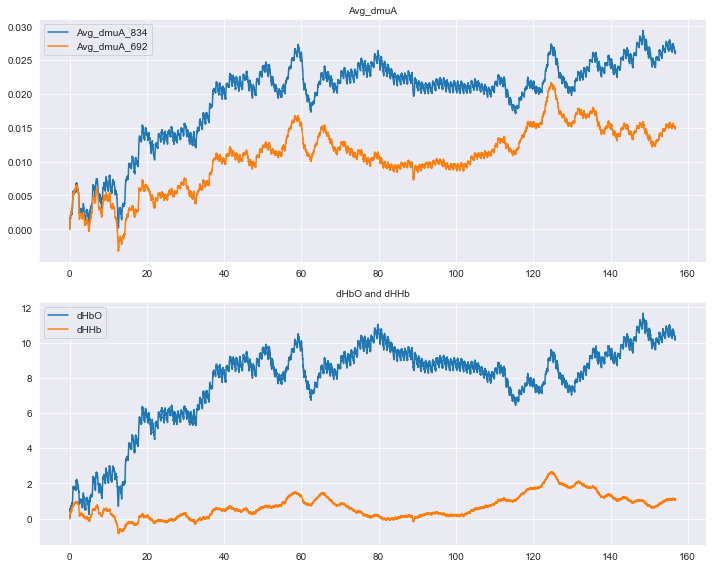

In [5]:
figure, axis = plt.subplots(2, 1, figsize=(10, 8))
#plt.subplots_adjust(hspace=1.0)
axis[0].set_title('Avg_dmuA', fontsize=10)
axis[0].plot(time, d_mua_lmbd2)
axis[0].plot(time, d_mua_lmbd1)
axis[0].legend(["Avg_dmuA_834", "Avg_dmuA_692"])
axis[1].set_title('dHbO and dHHb', fontsize=10)
axis[1].plot(time, d_hbo)
axis[1].plot(time, d_hhb)
axis[1].legend(["dHbO", "dHHb"])
plt.tight_layout()
plt.show()

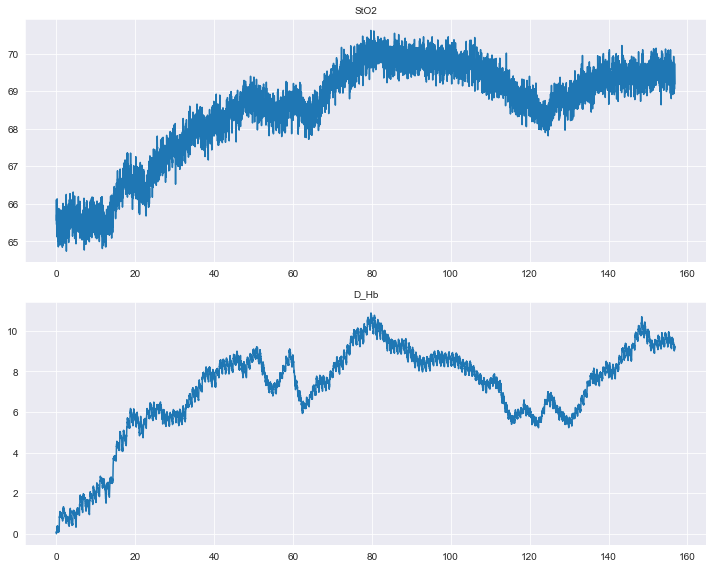

In [6]:
figure, axis = plt.subplots(2, 1, figsize=(10, 8))
#plt.subplots_adjust(hspace=1.0)
axis[0].set_title('StO2', fontsize=10)
axis[0].plot(time, sto2)

axis[1].set_title('D_Hb', fontsize=10)
axis[1].plot(time, d_hb)

plt.tight_layout()
plt.show()

Загрузка реальных значений искомых данных для сравнения.

In [7]:
df_real = pd.read_excel('data/Diodes1357_HbUa.xlsx')
thb_real = df_real["THC A"].values
hhb_real = df_real[" [De Oxy] A"].values
hbo_real = df_real[" [Oxy] A"].values

<a id='large_window'></a>
### Метод расширяющегося окна

(раздел 6.1.1 отчета)

График, показывающий неустойчивость метода расчета THb скользящим окном с пересчетом коэффициента регрессии для каждого интервала точек.

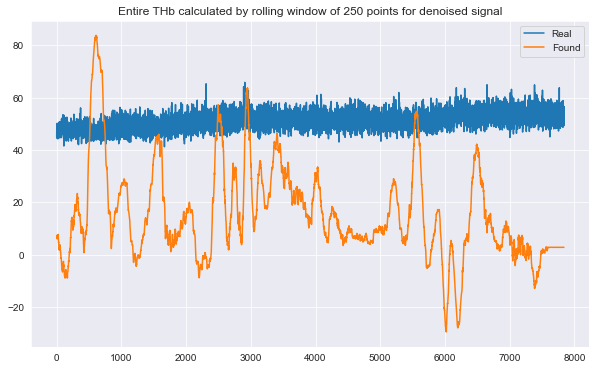

In [8]:
num_points = 250 # размер окна
calc_thb = []
for i in range(len(sto2) - num_points):
    coeffs = np.polyfit(sto2[i:i+num_points], d_hb[i:i+num_points], 1) # поиск коэффициента наклона
    k = coeffs[0]
    calc_thb.append(k * 50)
calc_thb = calc_thb + [calc_thb[-1]] * num_points

figure, axis = plt.subplots(1, 1, figsize=(10, 6))
plt.plot(thb_real)
plt.plot(np.array(calc_thb) * 0.9)
plt.legend(["Real", "Found"])
plt.title("Entire THb calculated by rolling window of 250 points for denoised signal")
plt.show()

Подсчет коэффициента регрессии для расширяющегося окна производится следующим образом: к исходному количеству точек на каждом шаге добавляется следующая из временного ряда, и производится расчет коэффициента регрессии по всем точкам вместе с новой. Эмпирическим путем получено, что график полученной последовательности коэффициентов имеет стандартный вид - после резкого роста график постепенно выходит на постоянный уровень. На следующем графике изображена последовательность коэффициентов, полученная описанным методом.

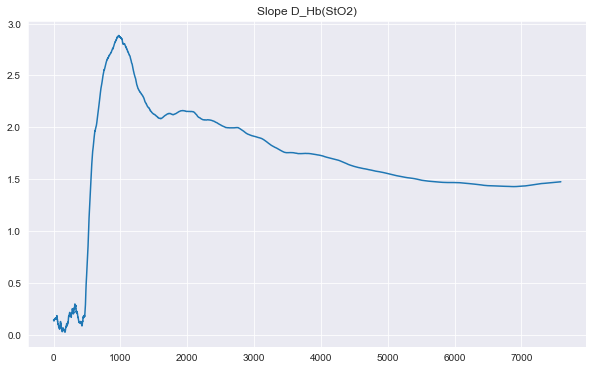

In [9]:
start_point = 250
total_slope = []
for i in range(len(sto2) - start_point):
    # slope, intercept, r_value, p_value, std_err = linregress(x, y)
    coeffs = np.polyfit(sto2[:start_point+i], d_hb[:start_point+i], 1)
    k = coeffs[0]
    total_slope.append(k)


figure, axis = plt.subplots(1, 1, figsize=(10, 6))
plt.plot(total_slope)
plt.title("Slope D_Hb(StO2)")
plt.show()

*Поиск точки перегиба последовательности коэффициентов путем сглаживания графика Гауссовым фильтром и поиска максимума производной.*

При использовании фильтра важно выбрать правильный параметр, так как слишком сильное сглаживание изменяет положение искомой точки.

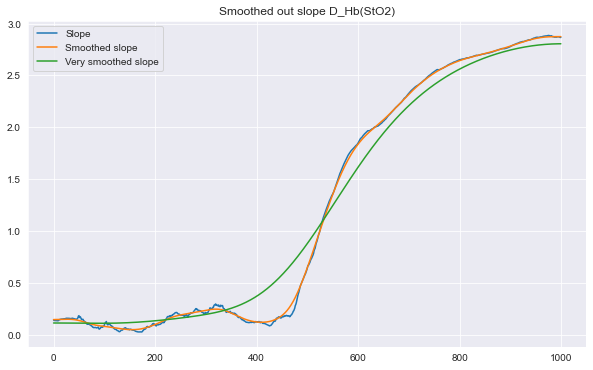

In [10]:
smooth = gaussian_filter1d(total_slope[:1000], 20)
figure, axis = plt.subplots(1, 1, figsize=(10, 6))
plt.plot(total_slope[:1000])
plt.plot(smooth)
plt.plot(gaussian_filter1d(total_slope[:1000], 100))
plt.legend(["Slope", "Smoothed slope", "Very smoothed slope"])
plt.title("Smoothed out slope D_Hb(StO2)")
plt.show()

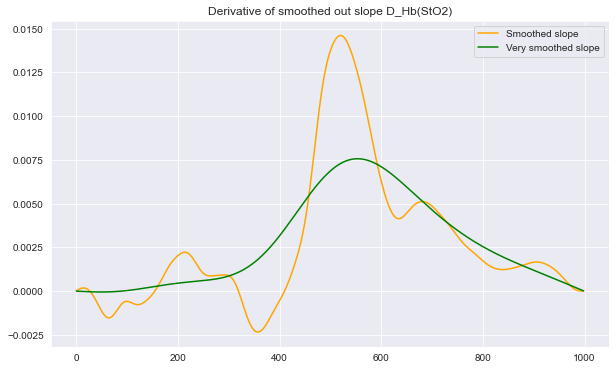

In [11]:
figure, axis = plt.subplots(1, 1, figsize=(10, 6))
plt.plot(np.diff(gaussian_filter1d(total_slope[:1000], 20)), 'orange')
plt.plot(np.diff(gaussian_filter1d(total_slope[:1000], 100)), 'g')
plt.legend(["Smoothed slope", "Very smoothed slope"])
plt.title("Derivative of smoothed out slope D_Hb(StO2)")
plt.show()

In [12]:
dy = np.diff(smooth) # поиск производной
index_max = np.argmax(dy) # индекс максимума
selected = 250 + index_max
sel_slope = total_slope[index_max]

t_hb0 = sel_slope * 50
found_thb = d_thb + (t_hb0 - d_thb[selected])

Восстановленные и реальные значения THb, HbO, HHb, вместе с относительным отклонением, его средним и среднеквадратичным отклонением от него. Относительное отклонение считалось как отношение значений разности полученного и реального сигналов к значениям реального сигнала.

Среднее относительного отклонения (%): 0.35
СКО отклонения (%): 1.59


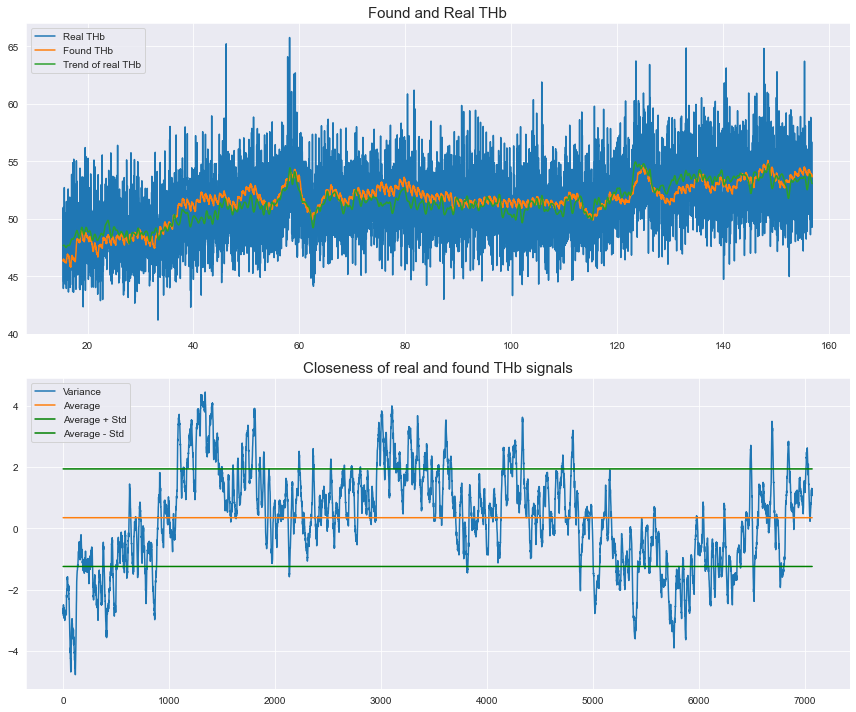

In [13]:
figure, axis = plt.subplots(2, 1, figsize=(12, 10))
#plt.subplots_adjust(hspace=1.0)
axis[0].set_title('Found and Real THb', fontsize=15)
axis[0].plot(time[selected:], thb_real[selected:])
axis[0].plot(time[selected:], found_thb[selected:])
axis[0].plot(time[selected:], gaussian_filter1d(thb_real[selected:], 10))
axis[0].legend(["Real THb", "Found THb", "Trend of real THb"])

trend_real = gaussian_filter1d(thb_real[selected:], 10)
variance = ((found_thb[selected:] - trend_real) / trend_real) * 100
aver = np.average(variance)
stdv = np.std(variance)

print("Среднее относительного отклонения (%):", np.round(aver, 2))
print("СКО отклонения (%):", np.round(stdv, 2))

axis[1].set_title("Closeness of real and found THb signals", fontsize=15)
axis[1].plot(variance)
axis[1].plot([aver] * len(variance))
axis[1].plot([aver + stdv] * len(variance), color='g')
axis[1].plot([aver - stdv] * len(variance), color='g')
axis[1].legend(["Variance", "Average", "Average + Std", "Average - Std"])
plt.tight_layout()
plt.show()

In [14]:
hbo0 = 0.01 * sto2[selected] * t_hb0
found_hbo = d_hbo + (hbo0 - d_hbo[selected])

Среднее относительного отклонения (%): -0.95
СКО отклонения (%): 3.15


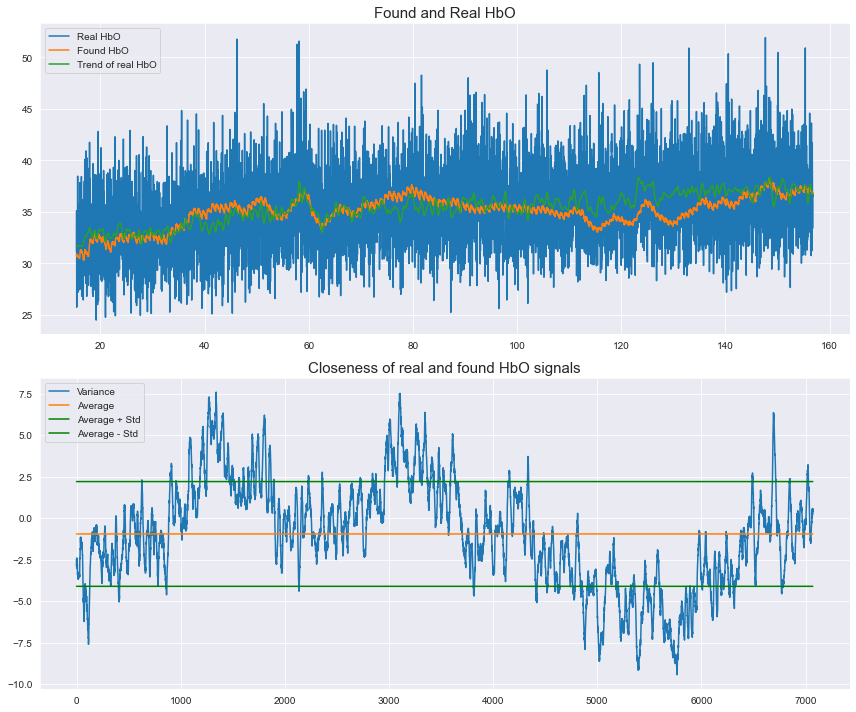

In [15]:
figure, axis = plt.subplots(2, 1, figsize=(12, 10))
#plt.subplots_adjust(hspace=1.0)
axis[0].set_title('Found and Real HbO', fontsize=15)
axis[0].plot(time[selected:], hbo_real[selected:])
axis[0].plot(time[selected:], found_hbo[selected:])
axis[0].plot(time[selected:], gaussian_filter1d(hbo_real[selected:], 10))
axis[0].legend(["Real HbO", "Found HbO", "Trend of real HbO"])

trend_real = gaussian_filter1d(hbo_real[selected:], 10)
variance = ((found_hbo[selected:] - trend_real) / trend_real) * 100
aver = np.average(variance)
stdv = np.std(variance)

print("Среднее относительного отклонения (%):", np.round(aver, 2))
print("СКО отклонения (%):", np.round(stdv, 2))

axis[1].set_title("Closeness of real and found HbO signals", fontsize=15)
axis[1].plot(variance)
axis[1].plot([aver] * len(variance))
axis[1].plot([aver + stdv] * len(variance), color='g')
axis[1].plot([aver - stdv] * len(variance), color='g')
axis[1].legend(["Variance", "Average", "Average + Std", "Average - Std"])
plt.tight_layout()
plt.show()

In [16]:
hhb0 = t_hb0 - hbo0
found_hhb = d_hhb + (hhb0 - d_hhb[selected])

Среднее относительного отклонения (%): 3.36
СКО отклонения (%): 3.71


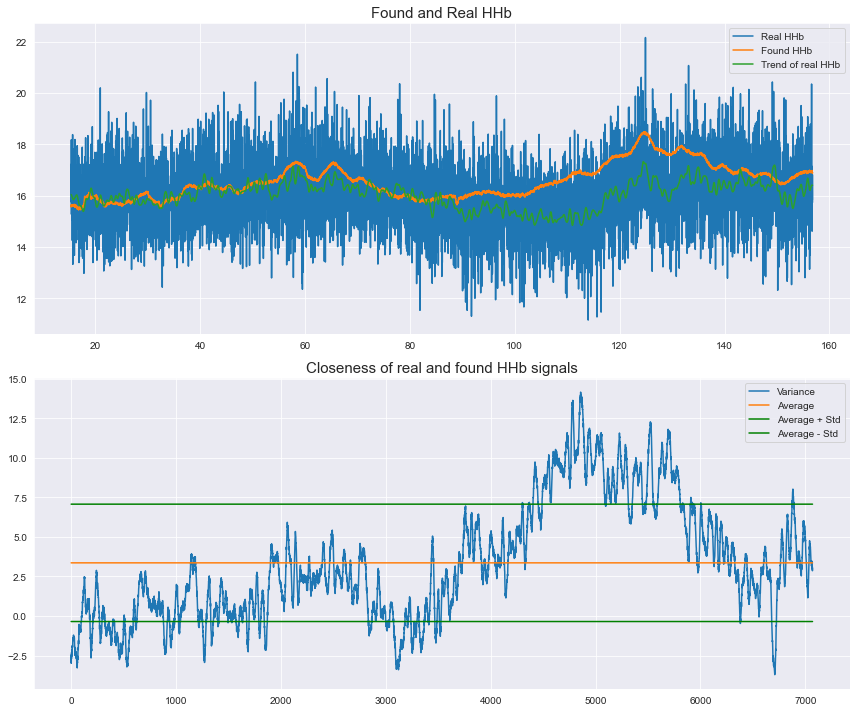

In [17]:
figure, axis = plt.subplots(2, 1, figsize=(12, 10))
#plt.subplots_adjust(hspace=1.0)
axis[0].set_title('Found and Real HHb', fontsize=15)
axis[0].plot(time[selected:], hhb_real[selected:])
axis[0].plot(time[selected:], found_hhb[selected:])
axis[0].plot(time[selected:], gaussian_filter1d(hhb_real[selected:], 10))
axis[0].legend(["Real HHb", "Found HHb", "Trend of real HHb"])

trend_real = gaussian_filter1d(hhb_real[selected:], 10)
variance = ((found_hhb[selected:] - trend_real) / trend_real) * 100
aver = np.average(variance)
stdv = np.std(variance)

print("Среднее относительного отклонения (%):", np.round(aver, 2))
print("СКО отклонения (%):", np.round(stdv, 2))

axis[1].set_title("Closeness of real and found HHb signals", fontsize=15)
axis[1].plot(variance)
axis[1].plot([aver] * len(variance))
axis[1].plot([aver + stdv] * len(variance), color='g')
axis[1].plot([aver - stdv] * len(variance), color='g')
axis[1].legend(["Variance", "Average", "Average + Std", "Average - Std"])
plt.tight_layout()
plt.show()

<a id='pulse'></a>
### Восстановление по пульсовым колебаниям

(раздел 6.1.2 отчета)

**Отрезок сигнала D_Hb без ярко выраженных дыхательных колебаний**

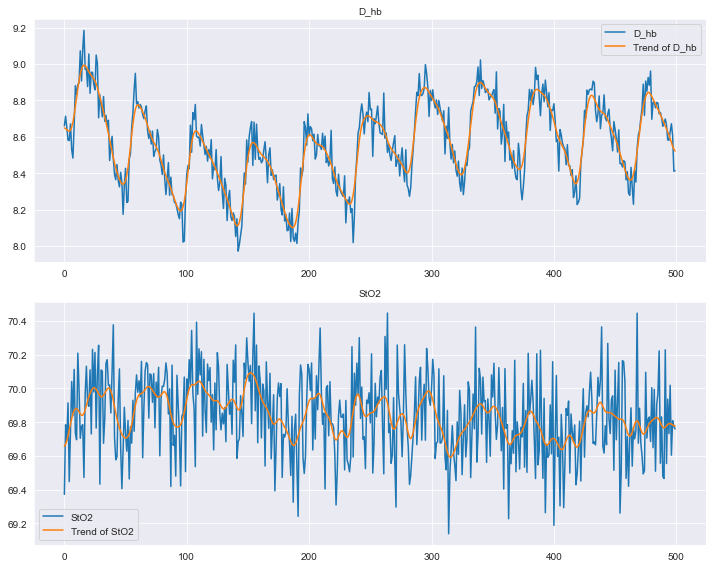

In [18]:
figure, axis = plt.subplots(2, 1, figsize=(10, 8))
#plt.subplots_adjust(hspace=1.0)
axis[0].set_title('D_hb', fontsize=10)
axis[0].plot(d_hb[90*50:100*50])
axis[0].plot(gaussian_filter1d(d_hb[90*50:100*50], 3))
axis[0].legend(["D_hb", "Trend of D_hb"])

axis[1].set_title('StO2', fontsize=10)
axis[1].plot(sto2[90*50:100*50])
axis[1].plot(gaussian_filter1d(sto2[90*50:100*50], 3))
axis[1].legend(["StO2", "Trend of StO2"])
plt.tight_layout()
plt.show()

Поиск участков восходящей фазы пульсовой волны в сигналах с помощью производной

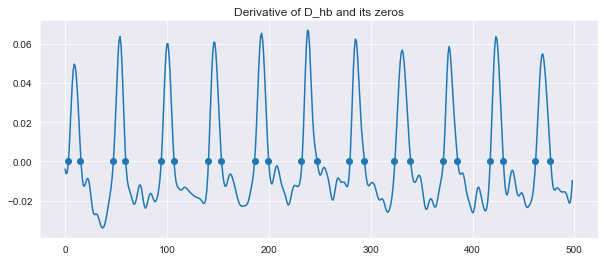

In [19]:
dhb_part = gaussian_filter1d(d_hb[90*50:100*50], 3) # выбор части сигнала для анализа
sto2_part = gaussian_filter1d(sto2[90*50:100*50], 3)

dy = np.diff(dhb_part)
pairs = []
zeros = []
first = -1
second = -1
for i in range(len(dy) - 1):
    if dy[i] <= 0 and dy[i + 1] >= 0:
        first = i
        zeros.append(i)
    elif dy[i] >= 0 and dy[i + 1] <= 0 and first != -1:
        pairs.append((first, i))
        zeros.append(i)
        first = -1

figure, axis = plt.subplots(1, 1, figsize=(10, 4))
plt.plot(np.diff(dhb_part))
plt.scatter(zeros, [0 for i in range(len(zeros))])
plt.title("Derivative of D_hb and its zeros")
plt.show()

Поиск искомого коэффициента как среднего арифметического коэффициентов, вычисленных на возрастающих (систолических) фазах пульсовой волны. Этапы возрастания были определены после нахождения нулей производной сглаженного сигнала D_Hb.

In [20]:
curr_dhb = gaussian_filter1d(d_hb[90*50:100*50], 1)
curr_sto2 = gaussian_filter1d(sto2[90*50:100*50], 1)

step = 2 # отступ от экстремума
slopes = []
for pair in pairs:
    start = pair[0] + step
    end = pair[1] - step
    if (end <= start):
        continue
    coeffs = np.polyfit(curr_sto2[start:end+1], curr_dhb[start:end+1], 1)
    k = coeffs[0]
    slopes.append(k)
found_k = np.average(slopes)
selected = (90 * 50 + 100 * 50) // 2

Восстановленные и реальные значения THb, HbO, HHb, вместе с относительным отклонением, его средним и среднеквадратичным отклонением от него. Относительное отклонение считалось как отношение значений разности полученного и реального сигналов к значениям реального сигнала.

Среднее относительного отклонения (%): 0.62
СКО отклонения (%): 1.41


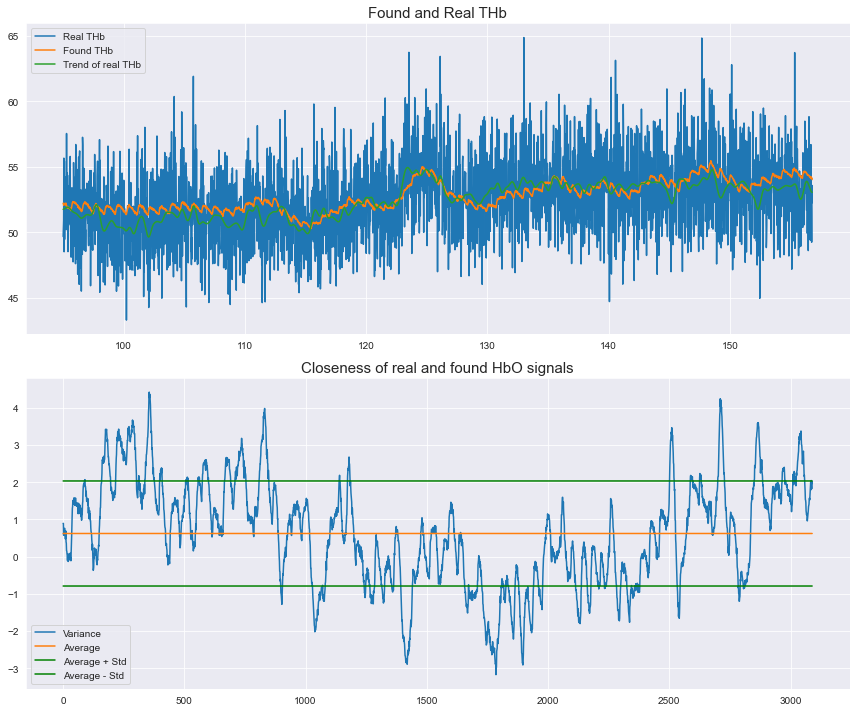

In [21]:
t_hb0 = found_k * 50
found_thb = d_thb + (t_hb0 - d_thb[selected])

figure, axis = plt.subplots(2, 1, figsize=(12, 10))
#plt.subplots_adjust(hspace=1.0)
axis[0].set_title('Found and Real THb', fontsize=15)
axis[0].plot(time[selected:], thb_real[selected:])
axis[0].plot(time[selected:], found_thb[selected:])
axis[0].plot(time[selected:], gaussian_filter1d(thb_real[selected:], 10))
axis[0].legend(["Real THb", "Found THb", "Trend of real THb"])

trend_real = gaussian_filter1d(thb_real[selected:], 10)
variance = ((found_thb[selected:] - trend_real) / trend_real) * 100
aver = np.average(variance)
stdv = np.std(variance)

print("Среднее относительного отклонения (%):", np.round(aver, 2))
print("СКО отклонения (%):", np.round(stdv, 2))

axis[1].set_title("Closeness of real and found HbO signals", fontsize=15)
axis[1].plot(variance)
axis[1].plot([aver] * len(variance))
axis[1].plot([aver + stdv] * len(variance), color='g')
axis[1].plot([aver - stdv] * len(variance), color='g')
axis[1].legend(["Variance", "Average", "Average + Std", "Average - Std"])
plt.tight_layout()
plt.show()

Среднее относительного отклонения (%): -0.79
СКО отклонения (%): 2.71


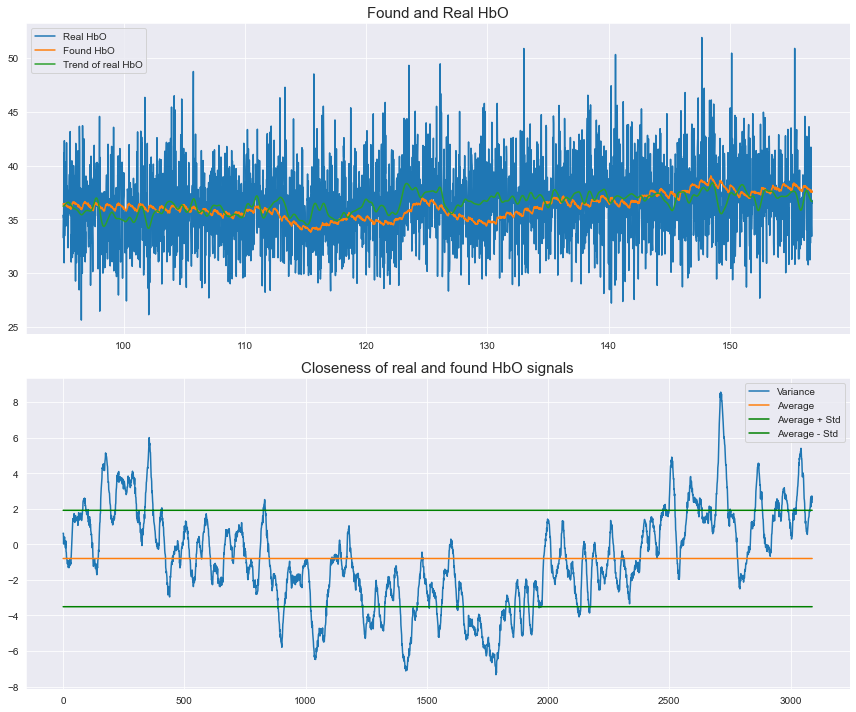

In [22]:
hbo0 = 0.01 * sto2[selected] * t_hb0
found_hbo = d_hbo + (hbo0 - d_hbo[selected])

figure, axis = plt.subplots(2, 1, figsize=(12, 10))
#plt.subplots_adjust(hspace=1.0)
axis[0].set_title('Found and Real HbO', fontsize=15)
axis[0].plot(time[selected:], hbo_real[selected:])
axis[0].plot(time[selected:], found_hbo[selected:])
axis[0].plot(time[selected:], gaussian_filter1d(hbo_real[selected:], 10))
axis[0].legend(["Real HbO", "Found HbO", "Trend of real HbO"])

trend_real = gaussian_filter1d(hbo_real[selected:], 10)
variance = ((found_hbo[selected:] - trend_real) / trend_real) * 100
aver = np.average(variance)
stdv = np.std(variance)

print("Среднее относительного отклонения (%):", np.round(aver, 2))
print("СКО отклонения (%):", np.round(stdv, 2))

axis[1].set_title("Closeness of real and found HbO signals", fontsize=15)
axis[1].plot(variance)
axis[1].plot([aver] * len(variance))
axis[1].plot([aver + stdv] * len(variance), color='g')
axis[1].plot([aver - stdv] * len(variance), color='g')
axis[1].legend(["Variance", "Average", "Average + Std", "Average - Std"])
plt.tight_layout()
plt.show()

Среднее относительного отклонения (%): 3.9
СКО отклонения (%): 3.19


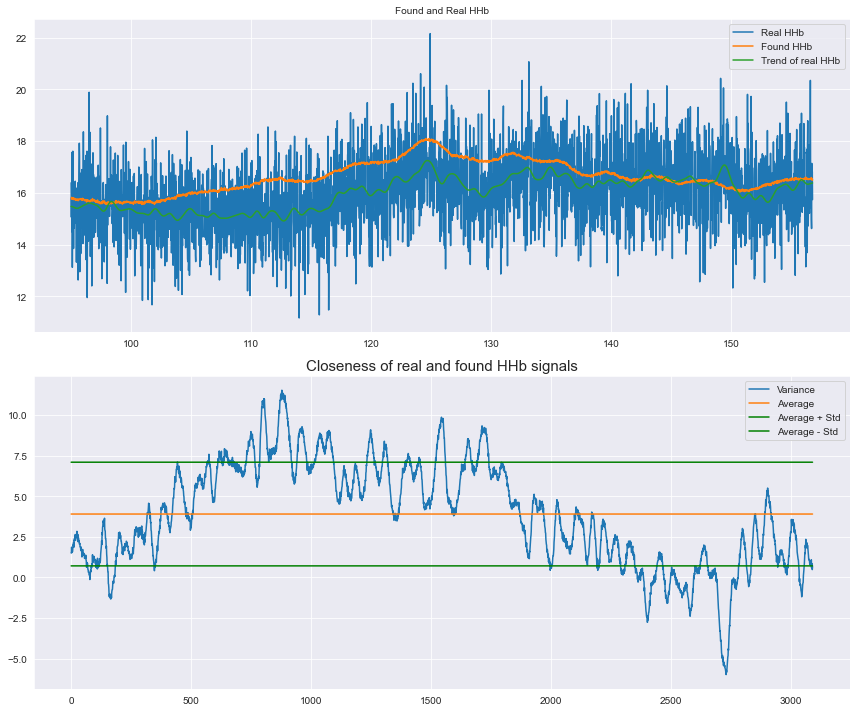

In [23]:
hhb0 = t_hb0 - hbo0
found_hhb = d_hhb + (hhb0 - d_hhb[selected])

figure, axis = plt.subplots(2, 1, figsize=(12, 10))
#plt.subplots_adjust(hspace=1.0)
axis[0].set_title('Found and Real HHb', fontsize=10)
axis[0].plot(time[selected:], hhb_real[selected:])
axis[0].plot(time[selected:], found_hhb[selected:])
axis[0].plot(time[selected:], gaussian_filter1d(hhb_real[selected:], 15))
axis[0].legend(["Real HHb", "Found HHb", "Trend of real HHb"])

trend_real = gaussian_filter1d(hhb_real[selected:], 10)
variance = ((found_hhb[selected:] - trend_real) / trend_real) * 100
aver = np.average(variance)
stdv = np.std(variance)

print("Среднее относительного отклонения (%):", np.round(aver, 2))
print("СКО отклонения (%):", np.round(stdv, 2))

axis[1].set_title("Closeness of real and found HHb signals", fontsize=15)
axis[1].plot(variance)
axis[1].plot([aver] * len(variance))
axis[1].plot([aver + stdv] * len(variance), color='g')
axis[1].plot([aver - stdv] * len(variance), color='g')
axis[1].legend(["Variance", "Average", "Average + Std", "Average - Std"])
plt.tight_layout()
plt.show()

**Отрезок сигнала D_Hb c ярко выраженными дыхательными колебаниями**

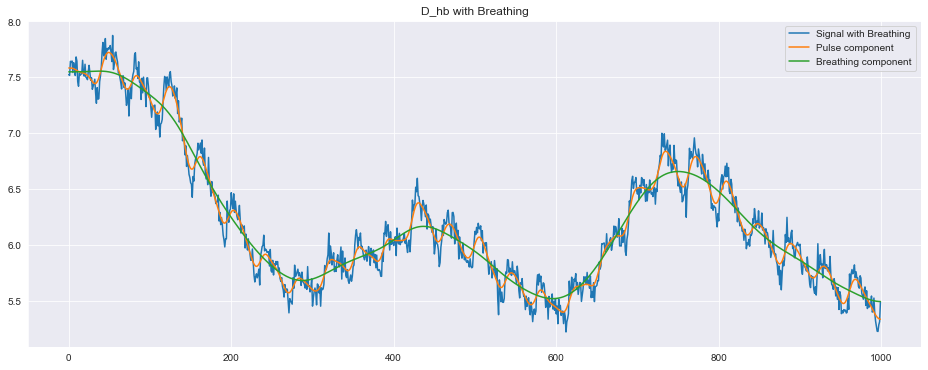

In [24]:
figure, axis = plt.subplots(1, 1, figsize=(16, 6))
plt.plot(d_hb[90*50+1000:90*50+2000])
plt.plot(gaussian_filter1d(d_hb[90*50+1000:90*50+2000], 5))
plt.plot(gaussian_filter1d(d_hb[90*50+1000:90*50+2000], 23))
plt.legend(["Signal with Breathing", "Pulse component", "Breathing component"])
plt.title("D_hb with Breathing")
plt.show()

EMD-разложение сигнала для удаления из него дыхательной компоненты

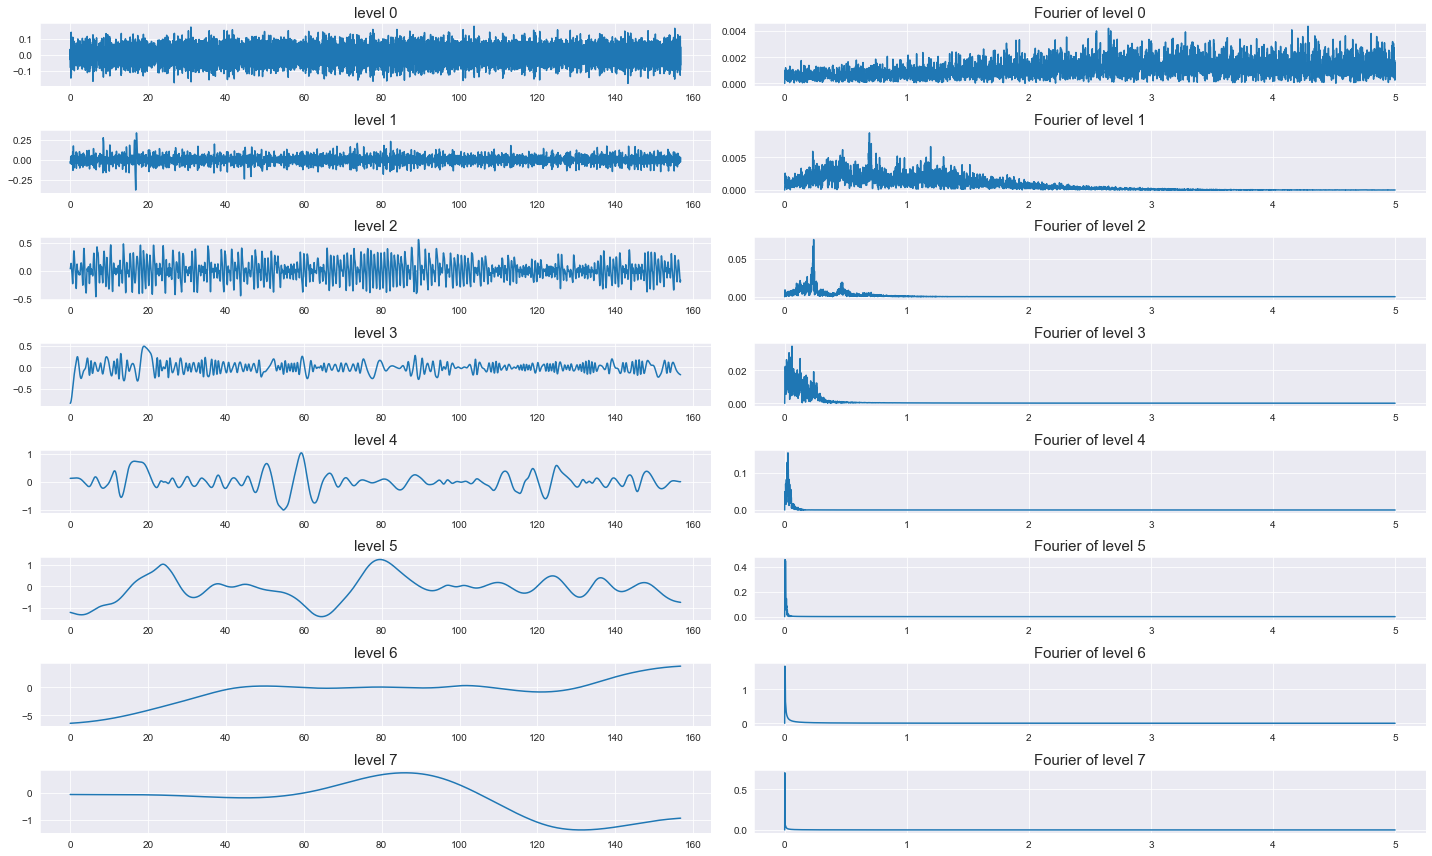

In [25]:
imf = emd.sift.sift(d_hb)
levels = imf.shape[1]
figure, axis = plt.subplots(levels, 2, figsize=(20, 12))
#plt.subplots_adjust(hspace=1.0)
for i in range(levels):
    axis[i][0].set_title('level '+str(i), fontsize=15)
    axis[i][0].plot(time, imf[:, i])

for i in range(levels):
    N = len(imf[:, i])
    spacing = 1 / 10
    fourierTransform = fft(imf[:, i] - np.average(imf[:, i]))
    frequencies = fftfreq(N, spacing)[: N // 2]
    axis[i][1].set_title('Fourier of level '+str(i), fontsize=15)
    axis[i][1].plot(frequencies, 2.0 / N * np.abs(fourierTransform[0 : N // 2]))

plt.tight_layout()
plt.show()

Сигнал до и после удаления дыхательной компоненты

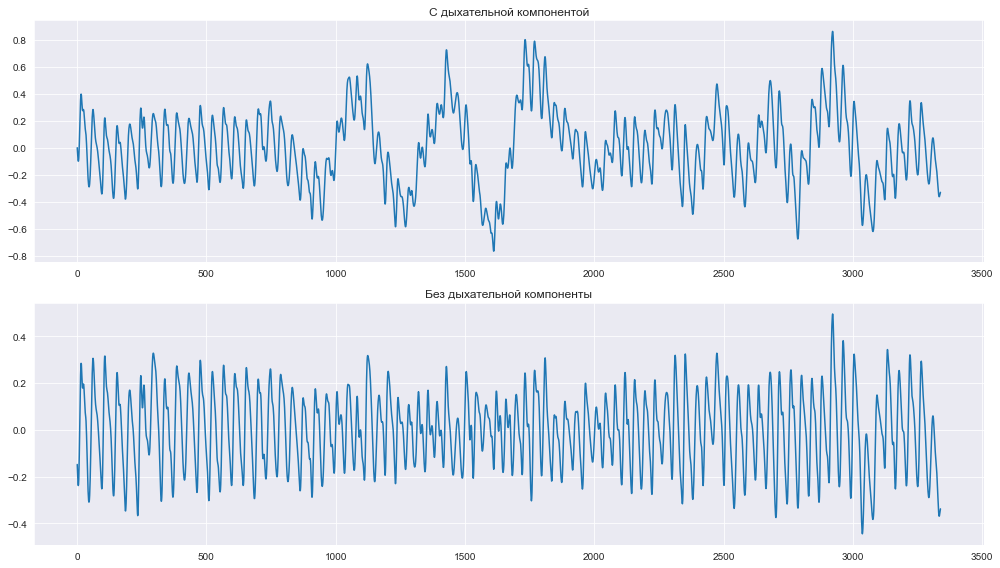

In [26]:
figure, axis = plt.subplots(2, 1, figsize=(14, 8))
axis[0].plot((imf[:, 2]+imf[:, 3]+imf[:, 4])[90*50:300*50])
axis[0].set_title("С дыхательной компонентой")

axis[1].plot((imf[:, 2]+imf[:, 3])[90*50:300*50])
axis[1].set_title("Без дыхательной компоненты")

plt.tight_layout()
plt.show()

Поиск периодов синфазности как участков вокруг локальных максимумов производной сигнала D_Hb, соответствующих точкам перегиба на возрастающих фронтах пульсовой волны. Локальные максимумы первой производной были найдены как нули сигнала, полученного путем взятия производной от сглаженной первой производной.

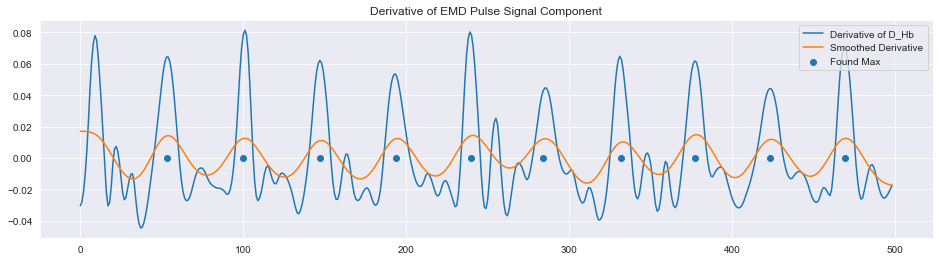

In [27]:
levels = (imf[:, 2]+imf[:, 3])[90*50:100*50]
dy = np.diff(levels)
ddy = np.diff(gaussian_filter1d(dy, 10))
pairs = []
zeros = []
first = -1
second = -1
for i in range(len(ddy) - 1):
    if ddy[i] <= 0 and ddy[i + 1] >= 0:
        first = i
    elif ddy[i] >= 0 and ddy[i + 1] <= 0 and first != -1:
        pairs.append((first, i))
        zeros.append(i)
        first = -1
figure, axis = plt.subplots(1, 1, figsize=(16, 4))
plt.plot(dy)
plt.plot(gaussian_filter1d(dy, 10))
plt.scatter(zeros, np.zeros(len(zeros)))
plt.legend(["Derivative of D_Hb", "Smoothed Derivative", "Found Max"])
plt.title("Derivative of EMD Pulse Signal Component")
plt.show()

Поиск коэффициента как среднего арифметического коэффициентов, вычисленных на участках синфазности

In [28]:
imf2 = emd.sift.sift(sto2)
levels = (imf[:, 2]+imf[:, 3])[120*50:130*50]
dy = np.diff(levels)
ddy = np.diff(gaussian_filter1d(dy, 10))
zeros = []
first = -1
second = -1
for i in range(len(ddy) - 1):
    if ddy[i] <= 0 and ddy[i + 1] >= 0:
        first = i
        # zeros.append(i)
    elif ddy[i] >= 0 and ddy[i + 1] <= 0 and first != -1:
        pairs.append((first, i))
        zeros.append(i)
        first = -1
# print(zeros)
curr_dhb = (imf[:, 2]+imf[:, 3])[120*50:130*50]
curr_sto2 = (imf2[:, 2]+imf2[:, 3]+imf2[:, 4])[120*50:130*50]
step = 10
slopes = []
for zero in zeros:
    start = zero - step
    end = zero + step
    coeffs = np.polyfit(curr_sto2[start:end+1], curr_dhb[start:end+1], 1)
    k = coeffs[0]
    slopes.append(k)
valid = []
for i in slopes:
    if i > 0.5 and i < 1.5:
        valid.append(i)
found_k = np.average(np.array(valid))

Среднее относительного отклонения (%): -5.84
СКО отклонения (%): 1.36


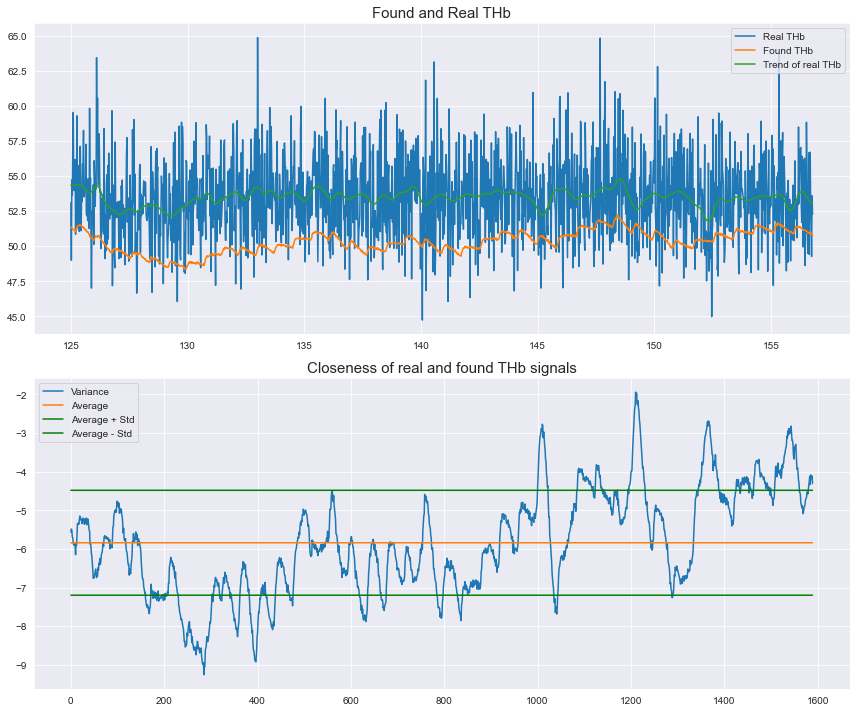

In [29]:
selected = (120 * 50 + 130 * 50) // 2
t_hb0 = found_k * 50
found_thb = d_thb + (t_hb0 - d_thb[selected])
figure, axis = plt.subplots(2, 1, figsize=(12, 10))
#plt.subplots_adjust(hspace=1.0)
axis[0].set_title('Found and Real THb', fontsize=15)
axis[0].plot(time[selected:], thb_real[selected:])
axis[0].plot(time[selected:], found_thb[selected:])
axis[0].plot(time[selected:], gaussian_filter1d(thb_real[selected:], 10))
axis[0].legend(["Real THb", "Found THb", "Trend of real THb"])

trend_real = gaussian_filter1d(thb_real[selected:], 10)
variance = ((found_thb[selected:] - trend_real) / trend_real) * 100
aver = np.average(variance)
stdv = np.std(variance)

print("Среднее относительного отклонения (%):", np.round(aver, 2))
print("СКО отклонения (%):", np.round(stdv, 2))

axis[1].set_title("Closeness of real and found THb signals", fontsize=15)
axis[1].plot(variance)
axis[1].plot([aver] * len(variance))
axis[1].plot([aver + stdv] * len(variance), color='g')
axis[1].plot([aver - stdv] * len(variance), color='g')
axis[1].legend(["Variance", "Average", "Average + Std", "Average - Std"])
plt.tight_layout()
plt.show()

Среднее относительного отклонения (%): -4.77
СКО отклонения (%): 2.83


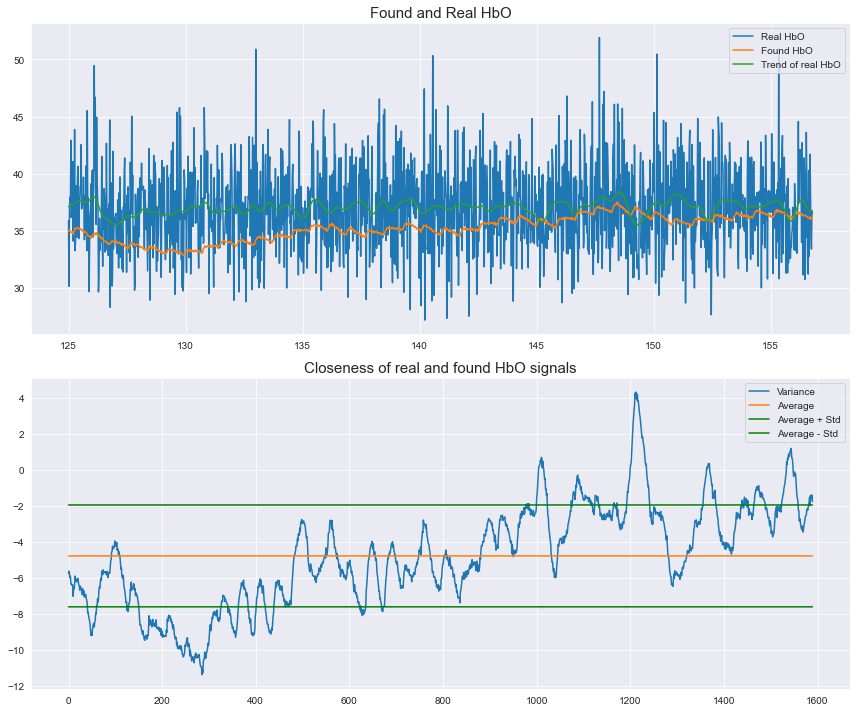

In [30]:
hbo0 = 0.01 * sto2[selected] * t_hb0
found_hbo = d_hbo + (hbo0 - d_hbo[selected])
figure, axis = plt.subplots(2, 1, figsize=(12, 10))
#plt.subplots_adjust(hspace=1.0)
axis[0].set_title('Found and Real HbO', fontsize=15)
axis[0].plot(time[selected:], hbo_real[selected:])
axis[0].plot(time[selected:], found_hbo[selected:])
axis[0].plot(time[selected:], gaussian_filter1d(hbo_real[selected:], 10))
axis[0].legend(["Real HbO", "Found HbO", "Trend of real HbO"])

trend_real = gaussian_filter1d(hbo_real[selected:], 10)
variance = ((found_hbo[selected:] - trend_real) / trend_real) * 100
aver = np.average(variance)
stdv = np.std(variance)

print("Среднее относительного отклонения (%):", np.round(aver, 2))
print("СКО отклонения (%):", np.round(stdv, 2))

axis[1].set_title("Closeness of real and found HbO signals", fontsize=15)
axis[1].plot(variance)
axis[1].plot([aver] * len(variance))
axis[1].plot([aver + stdv] * len(variance), color='g')
axis[1].plot([aver - stdv] * len(variance), color='g')
axis[1].legend(["Variance", "Average", "Average + Std", "Average - Std"])
plt.tight_layout()
plt.show()

Среднее относительного отклонения (%): -8.24
СКО отклонения (%): 2.89


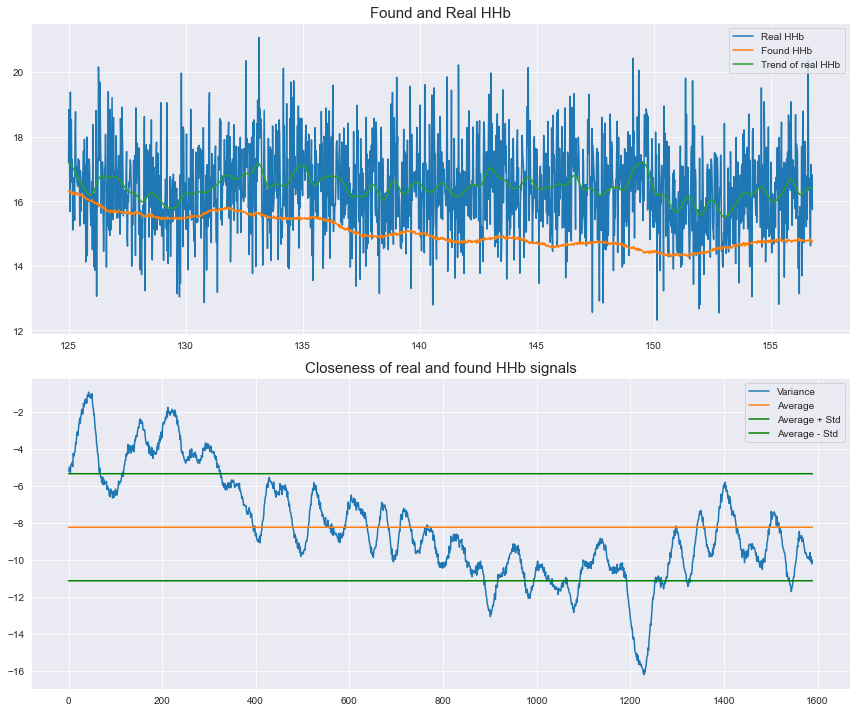

In [31]:
hhb0 = t_hb0 - hbo0
found_hhb = d_hhb + (hhb0 - d_hhb[selected])
figure, axis = plt.subplots(2, 1, figsize=(12, 10))
#plt.subplots_adjust(hspace=1.0)
axis[0].set_title('Found and Real HHb', fontsize=15)
axis[0].plot(time[selected:], hhb_real[selected:])
axis[0].plot(time[selected:], found_hhb[selected:])
axis[0].plot(time[selected:], gaussian_filter1d(hhb_real[selected:], 10))
axis[0].legend(["Real HHb", "Found HHb", "Trend of real HHb"])

trend_real = gaussian_filter1d(hhb_real[selected:], 10)
variance = ((found_hhb[selected:] - trend_real) / trend_real) * 100
aver = np.average(variance)
stdv = np.std(variance)

print("Среднее относительного отклонения (%):", np.round(aver, 2))
print("СКО отклонения (%):", np.round(stdv, 2))

axis[1].set_title("Closeness of real and found HHb signals", fontsize=15)
axis[1].plot(variance)
axis[1].plot([aver] * len(variance))
axis[1].plot([aver + stdv] * len(variance), color='g')
axis[1].plot([aver - stdv] * len(variance), color='g')
axis[1].legend(["Variance", "Average", "Average + Std", "Average - Std"])
plt.tight_layout()
plt.show()

<a id='breath'></a>
### Восстановление по дыхательным колебаниям

(раздел 6.1.3 отчета)

Попытка восстановления абсолютных значений по возрастающей фазе дыхательной волны

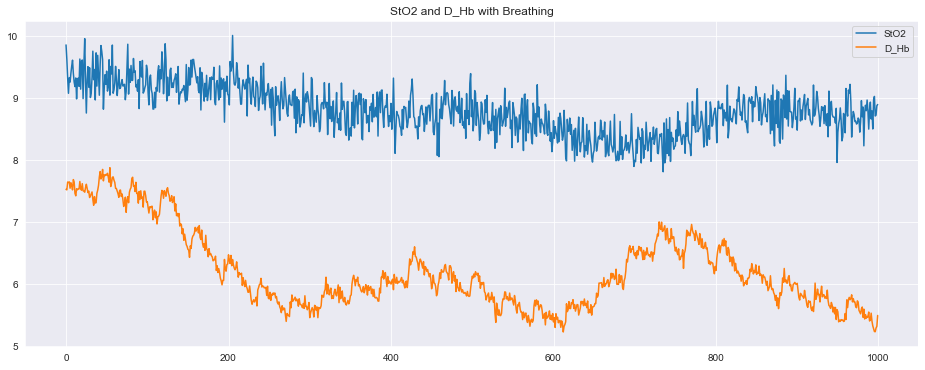

In [32]:
figure, axis = plt.subplots(1, 1, figsize=(16, 6))
plt.plot(sto2[90*50+1000:90*50+2000] - 60)
plt.plot(d_hb[90*50+1000:90*50+2000])
plt.legend(["StO2", "D_Hb"])
plt.title("StO2 and D_Hb with Breathing")
plt.show()

Среднее относительного отклонения (%): -58.36
СКО отклонения (%): 1.32


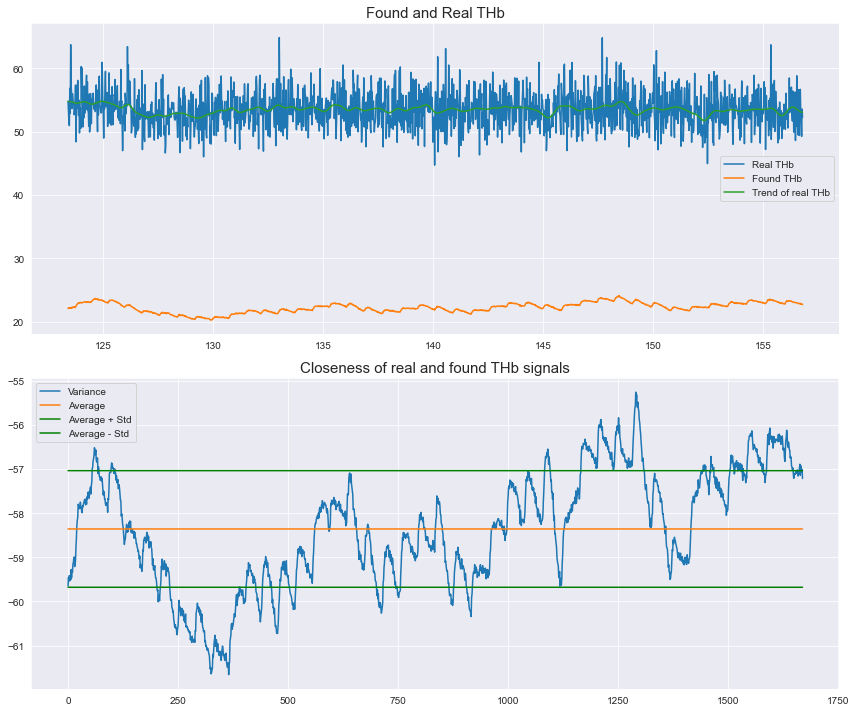

In [33]:
curr_dhb = gaussian_filter1d(d_hb[90*50+1000:90*50+2000], 1)[620:720]
curr_sto2 = gaussian_filter1d(sto2[90*50+1000:90*50+2000], 1)[620:720]
slope = np.polyfit(curr_sto2, curr_dhb, 1)[0]

selected = (90*50+1000+620 + 90*50+1000+720) // 2
t_hb0 = slope * (-1) * 50
found_thb = d_thb + (t_hb0 - d_thb[selected])
figure, axis = plt.subplots(2, 1, figsize=(12, 10))
#plt.subplots_adjust(hspace=1.0)
axis[0].set_title('Found and Real THb', fontsize=15)
axis[0].plot(time[selected:], thb_real[selected:])
axis[0].plot(time[selected:], found_thb[selected:])
axis[0].plot(time[selected:], gaussian_filter1d(thb_real[selected:], 10))
axis[0].legend(["Real THb", "Found THb", "Trend of real THb"])

trend_real = gaussian_filter1d(thb_real[selected:], 10)
variance = ((found_thb[selected:] - trend_real) / trend_real) * 100
aver = np.average(variance)
stdv = np.std(variance)

print("Среднее относительного отклонения (%):", np.round(aver, 2))
print("СКО отклонения (%):", np.round(stdv, 2))

axis[1].set_title("Closeness of real and found THb signals", fontsize=15)
axis[1].plot(variance)
axis[1].plot([aver] * len(variance))
axis[1].plot([aver + stdv] * len(variance), color='g')
axis[1].plot([aver - stdv] * len(variance), color='g')
axis[1].legend(["Variance", "Average", "Average + Std", "Average - Std"])
plt.tight_layout()
plt.show()

Попытка восстановления абсолютных значений методом расширяющегося окна

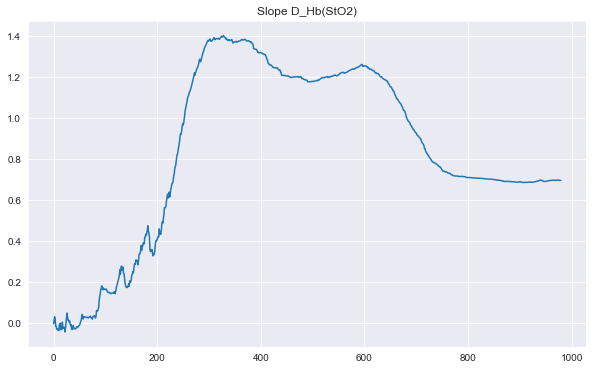

In [34]:
curr_sto2 = sto2[90 * 50 + 1000 : 90 * 50 + 2000]
curr_dhb = d_hb[90 * 50 + 1000 : 90 * 50 + 2000]

start_point = 20
total_slope = []
for i in range(len(curr_sto2) - start_point):
    coeffs = np.polyfit(curr_sto2[:start_point+i], curr_dhb[:start_point+i], 1)
    k = coeffs[0]
    total_slope.append(k)


figure, axis = plt.subplots(1, 1, figsize=(10, 6))
plt.plot(total_slope)
plt.title("Slope D_Hb(StO2)")
plt.show()

Поиск точки перегиба как максимума производной сглаженной функции D_Hb

In [35]:
smooth = gaussian_filter1d(total_slope[:400], 10)
dy = np.diff(smooth)
index_max = np.argmax(dy)
sel_slope = total_slope[index_max]

Восстановление исходных значений

Среднее относительного отклонения (%): -13.92
СКО отклонения (%): 1.3


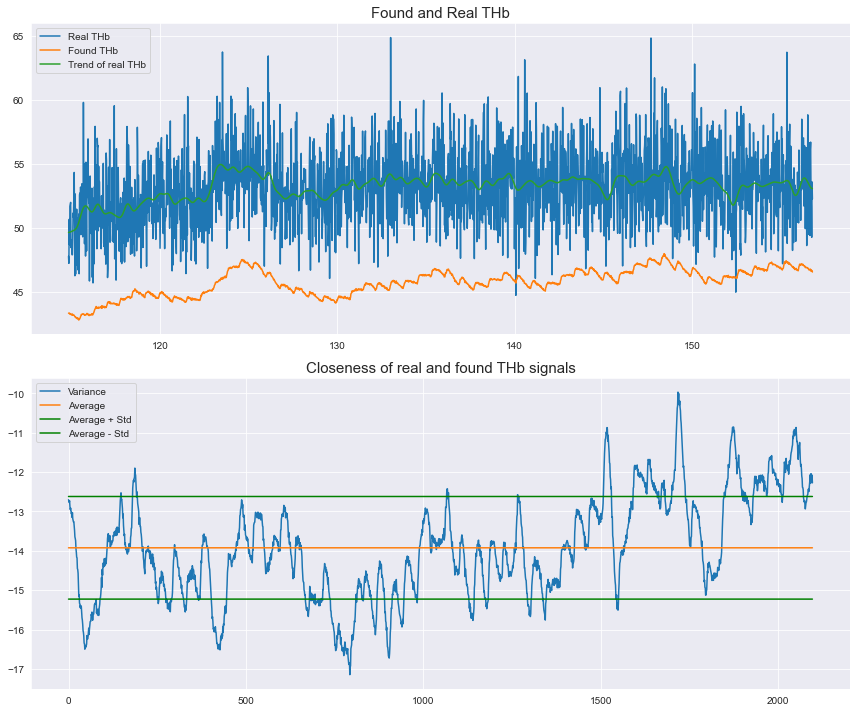

In [36]:
selected = 90 * 50 + 1000 + index_max
t_hb0 = sel_slope * 50
found_thb = d_thb + (t_hb0 - d_thb[selected])
figure, axis = plt.subplots(2, 1, figsize=(12, 10))
#plt.subplots_adjust(hspace=1.0)
axis[0].set_title('Found and Real THb', fontsize=15)
axis[0].plot(time[selected:], thb_real[selected:])
axis[0].plot(time[selected:], found_thb[selected:])
axis[0].plot(time[selected:], gaussian_filter1d(thb_real[selected:], 10))
axis[0].legend(["Real THb", "Found THb", "Trend of real THb"])

trend_real = gaussian_filter1d(thb_real[selected:], 10)
variance = ((found_thb[selected:] - trend_real) / trend_real) * 100
aver = np.average(variance)
stdv = np.std(variance)

print("Среднее относительного отклонения (%):", np.round(aver, 2))
print("СКО отклонения (%):", np.round(stdv, 2))

axis[1].set_title("Closeness of real and found THb signals", fontsize=15)
axis[1].plot(variance)
axis[1].plot([aver] * len(variance))
axis[1].plot([aver + stdv] * len(variance), color='g')
axis[1].plot([aver - stdv] * len(variance), color='g')
axis[1].legend(["Variance", "Average", "Average + Std", "Average - Std"])
plt.tight_layout()
plt.show()

Среднее относительного отклонения (%): -13.48
СКО отклонения (%): 2.82


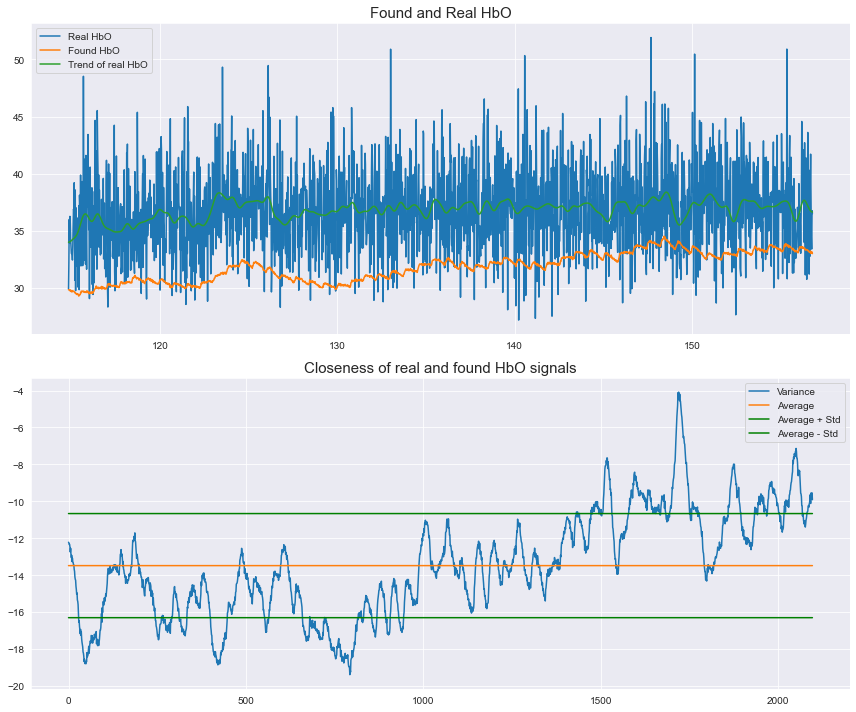

In [37]:
hbo0 = 0.01 * sto2[selected] * t_hb0
found_hbo = d_hbo + (hbo0 - d_hbo[selected])
figure, axis = plt.subplots(2, 1, figsize=(12, 10))
#plt.subplots_adjust(hspace=1.0)
axis[0].set_title('Found and Real HbO', fontsize=15)
axis[0].plot(time[selected:], hbo_real[selected:])
axis[0].plot(time[selected:], found_hbo[selected:])
axis[0].plot(time[selected:], gaussian_filter1d(hbo_real[selected:], 10))
axis[0].legend(["Real HbO", "Found HbO", "Trend of real HbO"])

trend_real = gaussian_filter1d(hbo_real[selected:], 10)
variance = ((found_hbo[selected:] - trend_real) / trend_real) * 100
aver = np.average(variance)
stdv = np.std(variance)

print("Среднее относительного отклонения (%):", np.round(aver, 2))
print("СКО отклонения (%):", np.round(stdv, 2))

axis[1].set_title("Closeness of real and found HbO signals", fontsize=15)
axis[1].plot(variance)
axis[1].plot([aver] * len(variance))
axis[1].plot([aver + stdv] * len(variance), color='g')
axis[1].plot([aver - stdv] * len(variance), color='g')
axis[1].legend(["Variance", "Average", "Average + Std", "Average - Std"])
plt.tight_layout()
plt.show()

Среднее относительного отклонения (%): -14.9
СКО отклонения (%): 2.97


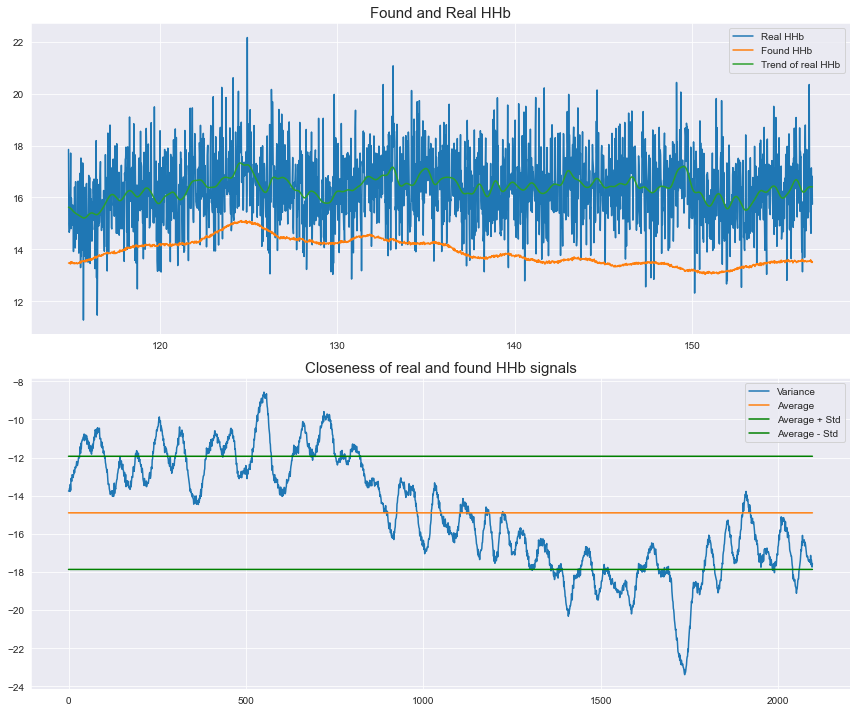

In [38]:
hhb0 = t_hb0 - hbo0
found_hhb = d_hhb + (hhb0 - d_hhb[selected])
figure, axis = plt.subplots(2, 1, figsize=(12, 10))
#plt.subplots_adjust(hspace=1.0)
axis[0].set_title('Found and Real HHb', fontsize=15)
axis[0].plot(time[selected:], hhb_real[selected:])
axis[0].plot(time[selected:], found_hhb[selected:])
axis[0].plot(time[selected:], gaussian_filter1d(hhb_real[selected:], 10))
axis[0].legend(["Real HHb", "Found HHb", "Trend of real HHb"])

trend_real = gaussian_filter1d(hhb_real[selected:], 10)
variance = ((found_hhb[selected:] - trend_real) / trend_real) * 100
aver = np.average(variance)
stdv = np.std(variance)

print("Среднее относительного отклонения (%):", np.round(aver, 2))
print("СКО отклонения (%):", np.round(stdv, 2))

axis[1].set_title("Closeness of real and found HHb signals", fontsize=15)
axis[1].plot(variance)
axis[1].plot([aver] * len(variance))
axis[1].plot([aver + stdv] * len(variance), color='g')
axis[1].plot([aver - stdv] * len(variance), color='g')
axis[1].legend(["Variance", "Average", "Average + Std", "Average - Std"])
plt.tight_layout()
plt.show()